In [1]:
# 라이브러리 import
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
import matplotlib.pyplot as plt

# 데이터셋을 저장할 디렉토리
DATA_DIR = "~/aiffel/cats_vs_dogs"

# 데이터 가져오기
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir=DATA_DIR,
    with_info=True,
    as_supervised=True,
)

IMG_SIZE = 160  # 리사이징할 이미지의 크기

# 이미지를 같은 포맷으로 통일, 픽셀값의 scale 수정
def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

# 원하는 모양의 데이터셋으로 변환
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

BATCH_SIZE = 32  # 한 스텝에 학습시킬 데이터의 개수
SHUFFLE_BUFFER_SIZE = 1000  # 학습 데이터를 적절히 섞어줄 사이즈

# BATCH_SIZE에 따라 데이터를 랜덤으로 뽑아 제공
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

# 하나의 batch를 꺼내 확인
for image_batch, label_batch in train_batches.take(1):
    pass


IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# 사전학습된 VGG16 모델을 base_model의 변수로 불러오기
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

# Global Average Pooling 계층을 만들기
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# 모델에 배치 넣기
feature_batch = base_model(image_batch)

# Global Average Pooling 계층에 feature_batch 넣기
feature_batch_average = global_average_layer(feature_batch)

# Dense 레이어 
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')

# feature_batch_averag가 dense_layer를 거친 결과가 다시 prediction_layer를 거치게 되면
prediction_batch = prediction_layer(dense_layer(feature_batch_average))  

base_model.trainable = False  # base_model은 학습을 시키지 않음

# 최종 모델
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

print("슝~")

58892288/58889256 [==============================] - 1s 0us/step
슝~


In [2]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])
print("슝~")

슝~


In [3]:
validation_steps=20
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 20s 134ms/step - loss: 0.6973 - accuracy: 0.5156
initial loss: 0.71
initial accuracy: 0.47


In [4]:
EPOCHS = 5   # 이번에는 이전보다 훨씬 빠르게 수렴되므로 5Epoch이면 충분합니다.

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/5
582/582 [==============================] - 223s 379ms/step - loss: 0.2494 - accuracy: 0.9107 - val_loss: 0.1779 - val_accuracy: 0.9282
Epoch 2/5
582/582 [==============================] - 193s 328ms/step - loss: 0.1592 - accuracy: 0.9349 - val_loss: 0.1553 - val_accuracy: 0.9316
Epoch 3/5
582/582 [==============================] - 198s 337ms/step - loss: 0.1462 - accuracy: 0.9406 - val_loss: 0.1531 - val_accuracy: 0.9372
Epoch 4/5
582/582 [==============================] - 199s 339ms/step - loss: 0.1394 - accuracy: 0.9429 - val_loss: 0.1419 - val_accuracy: 0.9398
Epoch 5/5
582/582 [==============================] - 199s 339ms/step - loss: 0.1344 - accuracy: 0.9458 - val_loss: 0.1386 - val_accuracy: 0.9415


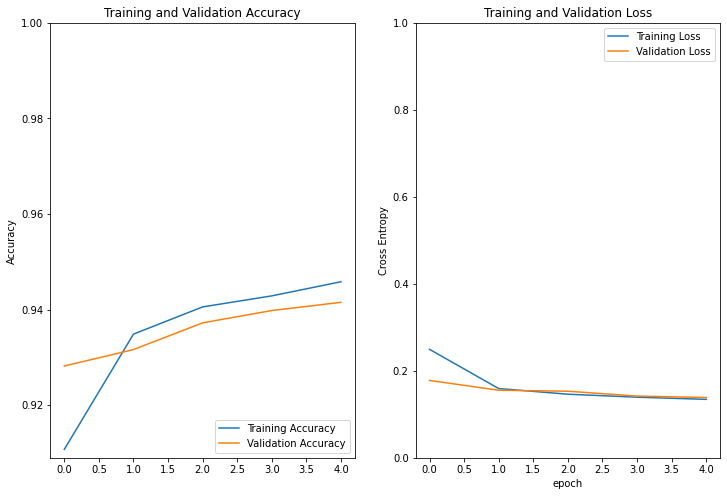

In [5]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [6]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[9.9998379e-01, 1.6214248e-05],
       [1.4326975e-01, 8.5673022e-01],
       [3.7261733e-01, 6.2738264e-01],
       [9.9999464e-01, 5.3517656e-06],
       [9.9835807e-01, 1.6418791e-03],
       [9.8863178e-01, 1.1368257e-02],
       [1.4914821e-04, 9.9985087e-01],
       [6.5704405e-01, 3.4295598e-01],
       [9.5869380e-01, 4.1306186e-02],
       [9.6508926e-01, 3.4910750e-02],
       [4.1323769e-05, 9.9995863e-01],
       [9.9995708e-01, 4.2894560e-05],
       [9.8892528e-01, 1.1074682e-02],
       [4.4784333e-06, 9.9999547e-01],
       [9.9814296e-01, 1.8570042e-03],
       [9.8879647e-01, 1.1203558e-02],
       [9.9770689e-01, 2.2931420e-03],
       [2.5420252e-02, 9.7457969e-01],
       [6.2687135e-01, 3.7312868e-01],
       [9.9500835e-01, 4.9915873e-03],
       [9.2577749e-01, 7.4222460e-02],
       [9.8088247e-01, 1.9117529e-02],
       [9.9366957e-01, 6.3304575e-03],
       [9.7566539e-01, 2.4334593e-02],
       [9.9848348e-01, 1.5165777e-03],
       [9.8541808e-01, 1.

In [7]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0])

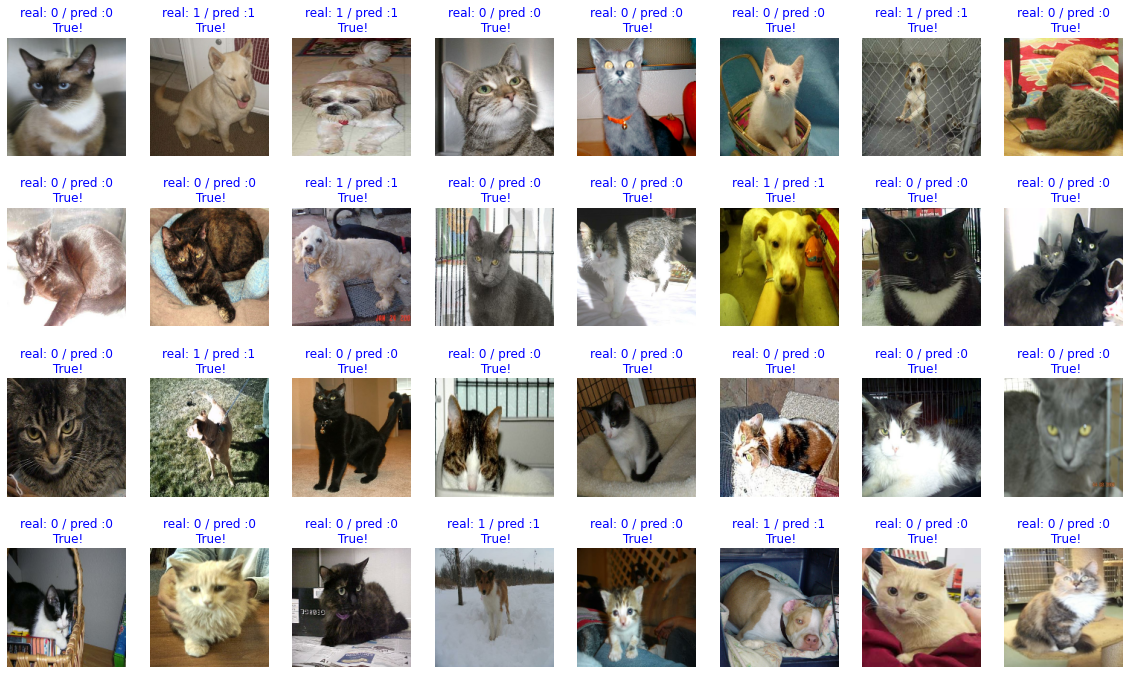

In [8]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [9]:
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100)

100.0


In [10]:
import os

checkpoint_dir = os.getenv("HOME") + "/aiffel/cats_vs_dogs/checkpoint"
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint')

if not os.path.exists('checkpoint_dir'):
    os.mkdir('checkpoint_dir')
    
model.save_weights(checkpoint_file_path)     # checkpoint 파일 생성

if os.path.exists(checkpoint_file_path):
  print('checkpoint 파일 생성 OK!!')

checkpoint 파일 생성 OK!!


In [20]:
img_dir_path = os.getenv("HOME") + "/aiffel/cats_vs_dogs/images"
os.path.exists(img_dir_path)

True

In [21]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
print("슝~")

슝~


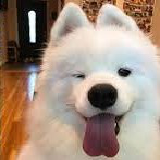

In [22]:
IMG_SIZE = 160
dog_image_path = os.path.join(img_dir_path, 'my_dog.jpg')

dog_image = load_img(dog_image_path, target_size=(IMG_SIZE, IMG_SIZE))
dog_image

In [23]:
dog_image = img_to_array(dog_image).reshape(1, IMG_SIZE, IMG_SIZE, 3)
dog_image.shape

(1, 160, 160, 3)

In [24]:
prediction = model.predict(dog_image)
prediction

array([[0., 1.]], dtype=float32)

In [25]:
def show_and_predict_image(dirpath, filename, img_size=160):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    prediction = model.predict(image)[0]
    cat_percentage = round(prediction[0] * 100)
    dog_percentage = round(prediction[1] * 100)
    print(f"This image seems {dog_percentage}% dog, and {cat_percentage}% cat.")

print("슝~")

슝~


This image seems 100% dog, and 0% cat.


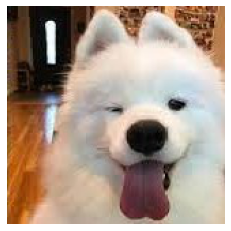

In [26]:
filename = 'my_dog.jpg'

show_and_predict_image(img_dir_path, filename)

This image seems 99% dog, and 1% cat.


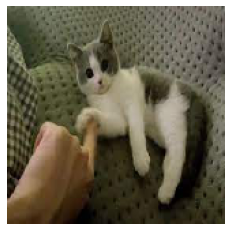

In [28]:
filename = 'my_cat.jpg'

show_and_predict_image(img_dir_path, filename)

This image seems 100% dog, and 0% cat.


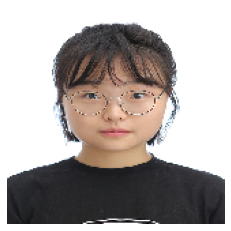

In [29]:
filename = "jooyoung.jpg"
show_and_predict_image(img_dir_path, filename)